In [1]:
import jCMIP as jc
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import numpy as np
import glob
from numpy import loadtxt
import xarray as xr
import scipy
from scipy.spatial import Delaunay


def alpha_shape(points, alpha, only_outer=True):
    """
    Compute the alpha shape (concave hull) of a set of points.
    :param points: np.array of shape (n,2) points.
    :param alpha: alpha value.
    :param only_outer: boolean value to specify if we keep only the outer border
    or also inner edges.
    :return: set of (i,j) pairs representing edges of the alpha-shape. (i,j) are
    the indices in the points array.
    """
    assert points.shape[0] > 3, "Need at least four points"

    def add_edge(edges, i, j):
        """
        Add a line between the i-th and j-th points,
        if not in the list already
        """
        if (i, j) in edges or (j, i) in edges:
            # already added
            assert (j, i) in edges, "Can't go twice over same directed edge right?"
            if only_outer:
                # if both neighboring triangles are in shape, it is not a boundary edge
                edges.remove((j, i))
            return
        edges.add((i, j))

    tri = Delaunay(points)
    edges = set()
    # Loop over triangles:
    # ia, ib, ic = indices of corner points of the triangle
    for ia, ib, ic in tri.simplices:
        pa = points[ia]
        pb = points[ib]
        pc = points[ic]
        # Computing radius of triangle circumcircle
        # www.mathalino.com/reviewer/derivation-of-formulas/derivation-of-formula-for-radius-of-circumcircle
        a = np.sqrt((pa[0] - pb[0]) ** 2 + (pa[1] - pb[1]) ** 2)
        b = np.sqrt((pb[0] - pc[0]) ** 2 + (pb[1] - pc[1]) ** 2)
        c = np.sqrt((pc[0] - pa[0]) ** 2 + (pc[1] - pa[1]) ** 2)
        s = (a + b + c) / 2.0
        area = np.sqrt(s * (s - a) * (s - b) * (s - c))
        circum_r = a * b * c / (4.0 * area)
        if circum_r < alpha:
            add_edge(edges, ia, ib)
            add_edge(edges, ib, ic)
            add_edge(edges, ic, ia)
    return edges

In [2]:
CMIP6list = 'CMIP6list'
jc.generateList('6',CMIP6list)
CList = jc.readList(CMIP6list)

starting models on list: 97
total models on list: 97


In [125]:
file_area = CList['IPSL-CM6A-LR'].getFiles(var='areacello')[0]
file_tos = CList['IPSL-CM6A-LR'].getFiles(EXP = 'historical', var='tos', vtype='Omon')[0]

dataset_tos = xr.load_dataset(file_tos)
dataset_area = xr.load_dataset(file_area)

dataset_area

<xarray.Dataset>
Dimensions:         (nvertex: 4, x: 362, y: 332)
Coordinates:
    nav_lat         (y, x) float32 -84.21 -84.21 -84.21 ... 50.23 50.01 50.01
    nav_lon         (y, x) float32 72.5 73.5 74.5 75.5 ... 73.04 73.0 72.99
Dimensions without coordinates: nvertex, x, y
Data variables:
    bounds_nav_lon  (y, x, nvertex) float32 72.5 72.5 72.5 ... 73.0 72.95 73.0
    bounds_nav_lat  (y, x, nvertex) float32 -84.21 -84.21 -84.21 ... 50.11 49.98
    area            (y, x) float32 16.0 16.0 16.0 ... 1.55e+08 3.18e+07 3.18e+07
    areacello       (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
Attributes: (12/49)
    name:                   /ccc/work/cont003/gencmip6/p86fair/IGCM_OUT/IPSLC...
    Conventions:            CF-1.7 CMIP-6.2
    creation_date:          2018-07-20T08:27:23Z
    tracking_id:            hdl:21.14100/e598cd02-6612-4bfd-aa12-e9e84edb8878
    description:            Conceptually similar to abrupt 4xCO2 DECK experim...
    title:                  IPSL-CM6A-LR model output prepared for CMIP6 / CF...
    ...                     ...
    variant_label:          r1i1p1f1
    EXPID:                  abrupt-solm4p
    CMIP6_CV_version:       cv=6.2.3.5-2-g63b123e
    dr2xml_md5sum:          d6225e658d7de0912fca2a4293dbe2a7
    model_version:          6.1.4
    history:                Sun Aug 12 21:40:04 2018: ncatted -O -a coordinat...

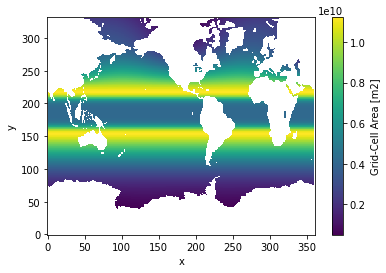

In [126]:
dataset_area.areacello.plot()

In [54]:
#dataset_area.areacello.where(dataset_area.areacello < 1e35).plot() for FGOALS

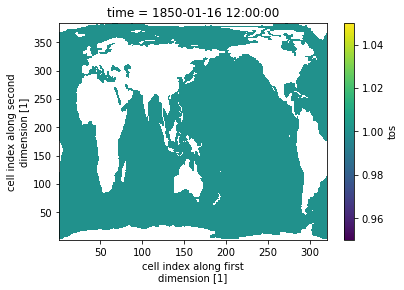

In [107]:
mask = dataset_tos.tos[0,:,:]/dataset_tos.tos[0,:,:]
mask.plot()

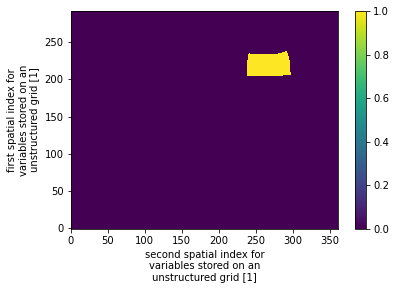

In [64]:
idx_amvlon = (dataset_area.longitude > 310) | (dataset_area.longitude < 10)
idx_amv1 = (dataset_area.latitude > 0) & (dataset_area.latitude < 60) & idx_amvlon
idx_amv2 = (dataset_area.latitude > 40) & (dataset_area.latitude < 60) & idx_amvlon
idx_amv2.plot()

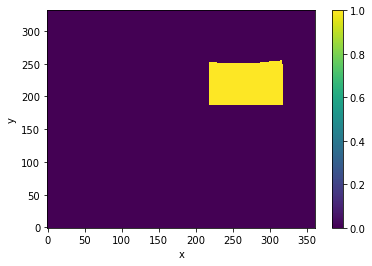

In [30]:
# for IPSL model, which has negative longitudes for wests
#idx_amvlon = (dataset_area.nav_lon > -50) & (dataset_area.nav_lon < 10)
#idx_amv1 = (dataset_area.nav_lat > 0) & (dataset_area.nav_lat < 60) & idx_amvlon
#idx_amv2 = (dataset_area.nav_lat > 40) & (dataset_area.nav_lat < 60) & idx_amvlon
#idx_sdlon = (dataset_area.nav_lon > -70) & (dataset_area.nav_lon < 30)
#idx_sd1 = (dataset_area.nav_lat > 45) & (dataset_area.nav_lat < 80) & idx_sdlon
#idx_sd2 = (dataset_area.nav_lat > 0) & (dataset_area.nav_lat < 45) & idx_sdlon
#idx_sd2.plot()

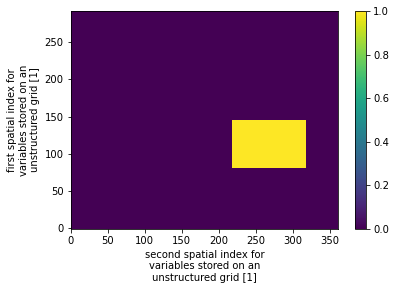

In [65]:
idx_sdlon = (dataset_area.longitude > 290) | (dataset_area.longitude < 30)
idx_sd1 = (dataset_area.latitude > 45) & (dataset_area.latitude < 80) & idx_sdlon
idx_sd2 = (dataset_area.latitude > -45) & (dataset_area.latitude < 0) & idx_sdlon
idx_sd2.plot()

In [66]:
box_amv1 = idx_amv1 * dataset_area.areacello #* mask
box_amv2 = idx_amv2 * dataset_area.areacello #* mask
box_sd1 = idx_sd1 * dataset_area.areacello #* mask
box_sd2 = idx_sd2 * dataset_area.areacello #* mask

sst_boxes = xr.merge([box_amv1.to_dataset(name='box_amv1'), box_amv2.to_dataset(name='box_amv2'), box_sd1.to_dataset(name='box_sd1'), box_sd2.to_dataset(name='box_sd2')] )
sst_boxes

<xarray.Dataset>
Dimensions:    (i: 292, j: 362)
Coordinates:
  * i          (i) int32 0 1 2 3 4 5 6 7 8 ... 284 285 286 287 288 289 290 291
  * j          (j) int32 0 1 2 3 4 5 6 7 8 ... 354 355 356 357 358 359 360 361
    latitude   (i, j) float64 -78.39 -78.39 -78.39 -78.39 ... 50.23 50.01 50.01
    longitude  (i, j) float64 72.5 73.5 74.5 75.5 ... 73.05 73.04 73.0 72.99
Data variables:
    box_amv1   (i, j) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    box_amv2   (i, j) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    box_sd1    (i, j) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    box_sd2    (i, j) float32 nan nan nan nan nan nan ... nan nan nan nan nan

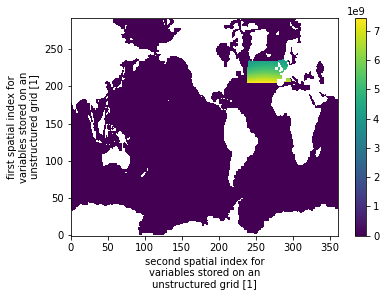

In [67]:
box_amv2.plot()

In [68]:
dir_output = '/home/users/keturner/HACKATHON/project04/data/processed_data/sst_boxes/'
sst_boxes.to_netcdf(dir_output+'CMCC-CM2-SR5_SSTareas.nc', mode='w')

In [131]:
# for subpolar gyre SST boxes start here
sg_locs = loadtxt('/home/users/keturner/HACKATHON/project04/data/processed_data/sst_boxes/sg_grid.txt')
sg_lines = alpha_shape(sg_locs, 4, only_outer=True)
sg_outline = np.reshape(list(sg_lines),[154,1])
np.unique(sg_outline)
sg_outline_lat = sg_locs[sg_outline,0]
sg_outline_lon = sg_locs[sg_outline,1] 

sg_outline_lon[sg_outline_lat==42.5]
lats = np.unique(sg_locs[:,0])

#overall boundaries for larger shape, need to get rid of concave area
wref_lon=np.zeros(np.shape(lats)[0])
eref_lon=np.zeros(np.shape(lats)[0])
for i in np.arange(np.shape(lats)[0]):
    ref_lat = lats[i]
    wref_lon[i] = np.min(sg_locs[sg_locs[:,0]==ref_lat, 1])
    eref_lon[i] = np.max(sg_locs[sg_locs[:,0]==ref_lat, 1])

## for positive longitudes we now have to subtract these from 360
#wref_lon = wref_lon + 360
#eref_lon = eref_lon + 360

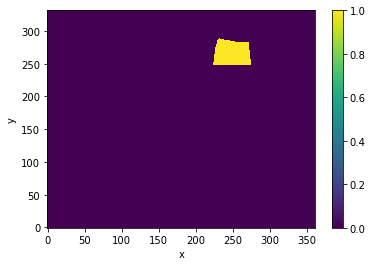

In [132]:
# for IPSL model, which has negative longitudes, first set box for sampling
idx_sglon = (dataset_area.nav_lon > -64) & (dataset_area.nav_lon < -13)
idx_sg = (dataset_area.nav_lat > 42) & (dataset_area.nav_lat < 66) & idx_sglon
idx_sg.plot()

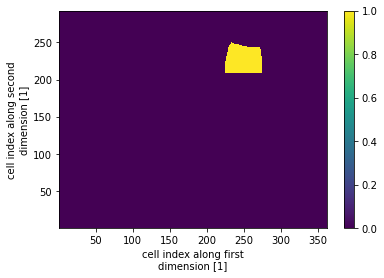

In [122]:
# for all other models, which have positive longitudes, first set box for sampling
idx_sglon = (dataset_area.longitude > 296) & (dataset_area.longitude < 347)
idx_sg = (dataset_area.latitude > 42) & (dataset_area.latitude < 66) & idx_sglon
idx_sg.plot()

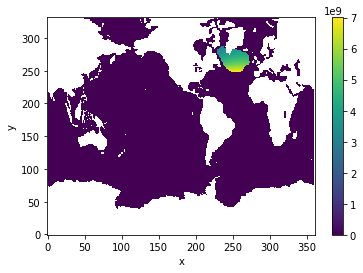

In [133]:
for j in np.arange(dataset_area.nav_lat.shape[0]):
    for i in np.arange(dataset_area.nav_lat.shape[1]):
        if idx_sg[j,i] == True: # in the larger box, so test if it is within bounds
            # find closest latitude
            ref_lat = np.floor(dataset_area.nav_lat[j,i]) + 0.5
            # test if longitude is within boundaries
            if (dataset_area.nav_lon[j,i].data > eref_lon[lats == ref_lat.data]) | (dataset_area.nav_lon[j,i].data < wref_lon[lats == ref_lat.data]):
                idx_sg[j,i] = False
                
box_sg = idx_sg * dataset_area.areacello #* mask
box_sg.plot()

In [134]:
dir_output = '/home/users/keturner/HACKATHON/project04/data/processed_data/sst_boxes/'
box_sg.to_netcdf(dir_output+'IPSL-CM6A-LR_subpolarSSTarea.nc', mode='w')